# 🔧 Data Processing - Cardio Train Dataset


In [39]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from kmodes.kmodes import KModes
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Tạo folder structure
os.makedirs('processed/cardio_train', exist_ok=True)

print("✅ Libraries imported & folders created!")


✅ Libraries imported & folders created!


## 1. Load Data


In [40]:
df = pd.read_csv('cardio_train.csv', sep=';').drop('id', axis=1)
print(f"Shape: {df.shape}")
df.head()


Shape: (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 2. Outlier Removal


In [41]:
# Remove outliers (quantile 2.5% - 97.5%)
print(f"Before: {len(df):,}")
for col in ['ap_hi', 'ap_lo', 'weight', 'height']:
    df = df[(df[col] >= df[col].quantile(0.025)) & (df[col] <= df[col].quantile(0.975))]
print(f"After: {len(df):,}")


Before: 70,000
After: 60,752


## 3. Feature Engineering


In [42]:
# Create derived features
df['age_in_years'] = (df['age'] / 365).round().astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['map'] = ((2 * df['ap_lo']) + df['ap_hi']) / 3
df.head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_in_years,bmi,map
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,90.000000
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,106.666667
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805,90.000000
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,116.666667
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177,73.333333


In [43]:
# Binning
age_bins = [30, 35, 40, 45, 50, 55, 60, 65]
df['age_bin'] = pd.cut(df['age_in_years'], bins=age_bins, labels=list(range(7)), right=False, include_lowest=True)

bmi_bins = [0, 18.5, 25, 30, 35, 40, np.inf]
df['BMI_Class'] = pd.cut(df['bmi'], bins=bmi_bins, labels=list(range(6)), right=False)

map_bins = [0, 70, 80, 90, 100, 110, np.inf]
df['MAP_Class'] = pd.cut(df['map'], bins=map_bins, labels=list(range(6)), right=False)

print(f"age_bin: {df['age_bin'].value_counts().sort_index().to_dict()}")
print(f"BMI_Class: {df['BMI_Class'].value_counts().sort_index().to_dict()}")
print(f"MAP_Class: {df['MAP_Class'].value_counts().sort_index().to_dict()}")


age_bin: {0: 4, 1: 340, 2: 8255, 3: 7548, 4: 16822, 5: 13994, 6: 13476}
BMI_Class: {0: 127, 1: 22855, 2: 22969, 3: 10867, 4: 3353, 5: 581}
MAP_Class: {0: 0, 1: 1162, 2: 9455, 3: 30600, 4: 12939, 5: 6596}


In [44]:
# Drop raw columns, keep processed
df_processed = df.drop(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'age_in_years', 'bmi', 'map'], axis=1)
final_cols = ['gender', 'age_bin', 'BMI_Class', 'MAP_Class', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
df_processed = df_processed[final_cols].dropna()

print(f"Shape: {df_processed.shape}")
df_processed.head()


Shape: (60439, 10)


,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio
0,2,4,1,3,1,1,0,0,1,0
1,1,5,3,4,3,1,0,0,1,1
2,1,4,1,3,3,1,0,0,0,1
3,2,3,2,5,1,1,0,0,1,1
4,1,3,1,1,1,1,0,0,0,0


## 4. K-Modes Clustering


In [45]:
# K-Modes Clustering (k=2, separate by gender)
df_male = df_processed[df_processed['gender'] == 2].copy()
df_female = df_processed[df_processed['gender'] == 1].copy()

km_male = KModes(n_clusters=2, init='Huang', n_init=5, random_state=42)
df_male['cluster'] = km_male.fit_predict(df_male)

km_female = KModes(n_clusters=2, init='Huang', n_init=5, random_state=42)
df_female['cluster'] = km_female.fit_predict(df_female)

df_final = pd.concat([df_male, df_female], ignore_index=True)
print(f"Shape: {df_final.shape}")
print(f"Clusters: {df_final['cluster'].value_counts().to_dict()}")


Shape: (60439, 11)
Clusters: {0: 39674, 1: 20765}


In [46]:
print(f"Columns: {list(df_final.columns)}")
df_final.head()


Columns: ['gender', 'age_bin', 'BMI_Class', 'MAP_Class', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'cluster']


,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio,cluster
0,2,4,1,3,1,1,0,0,1,0,0
1,2,3,2,5,1,1,0,0,1,1,1
2,2,6,2,4,3,3,0,0,1,1,1
3,2,4,1,3,1,1,0,0,1,0,0
4,2,2,1,3,1,1,0,0,0,0,0


## 5. Prepare Data for ML - Convert to Numeric Arrays


In [47]:
# Convert to numeric arrays
df_numeric = df_final.copy()
for col in df_numeric.columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')
df_numeric.dropna(inplace=True)

X = df_numeric.drop('cardio', axis=1).values.astype(np.float32)
y = df_numeric['cardio'].values.astype(np.int64)

print(f"X: {X.shape}, y: {y.shape}")
print(f"Class 0: {(y==0).sum():,} ({(y==0).mean()*100:.1f}%) | Class 1: {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")


X: (60439, 10), y: (60439,)
Class 0: 30,771 (50.9%) | Class 1: 29,668 (49.1%)


## 6. Train / Test Split + K-Fold Cross-Validation Setup


In [48]:
# Tách Test set cố định (20%) để đảm bảo fair comparison
# Sau đó sử dụng K-Fold Cross-Validation trên training data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("="*60)
print("📊 DATA SPLITTING STRATEGY")
print("="*60)
print(f"Full Dataset: {X.shape[0]:,} samples")
print(f"Training Set (80%): {X_train_full.shape[0]:,} samples")
print(f"Test Set (20% - Cố định): {X_test.shape[0]:,} samples")
print(f"\nClass distribution in Training: {(y_train_full==1).mean()*100:.1f}% positive")
print(f"Class distribution in Test: {(y_test==1).mean()*100:.1f}% positive")

# Tạo Stratified K-Fold (K=5) cho Cross-Validation
# Điều này đảm bảo mỗi fold đều có phân bố class cân bằng
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Lưu indices của các fold
fold_indices = []
fold_splits = list(skf.split(X_train_full, y_train_full))

print(f"\n✅ Created {N_FOLDS}-Fold Stratified Cross-Validation")
print("="*60)


📊 DATA SPLITTING STRATEGY
Full Dataset: 60,439 samples
Training Set (80%): 48,351 samples
Test Set (20% - Cố định): 12,088 samples

Class distribution in Training: 49.1% positive
Class distribution in Test: 49.1% positive

✅ Created 5-Fold Stratified Cross-Validation


## 7. Validate K-Fold Distribution


📊 Class Distribution trong các Fold:
------------------------------------------------------------
Fold 1: Train=38,680 (Pos: 49.1%) | Val=9,671 (Pos: 49.1%)
Fold 2: Train=38,681 (Pos: 49.1%) | Val=9,670 (Pos: 49.1%)
Fold 3: Train=38,681 (Pos: 49.1%) | Val=9,670 (Pos: 49.1%)
Fold 4: Train=38,681 (Pos: 49.1%) | Val=9,670 (Pos: 49.1%)
Fold 5: Train=38,681 (Pos: 49.1%) | Val=9,670 (Pos: 49.1%)

📈 Statistics:
           Fold    Train Size     Val Size  Train Pos %  Val Pos %
count  5.000000      5.000000     5.000000     5.000000   5.000000
mean   3.000000  38680.800000  9670.200000    49.086885  49.086886
std    1.581139      0.447214     0.447214     0.001154   0.004614
min    1.000000  38680.000000  9670.000000    49.086115  49.079628
25%    2.000000  38681.000000  9670.000000    49.086115  49.084893
50%    3.000000  38681.000000  9670.000000    49.086115  49.089969
75%    4.000000  38681.000000  9670.000000    49.087384  49.089969
max    5.000000  38681.000000  9671.000000    49.088700 

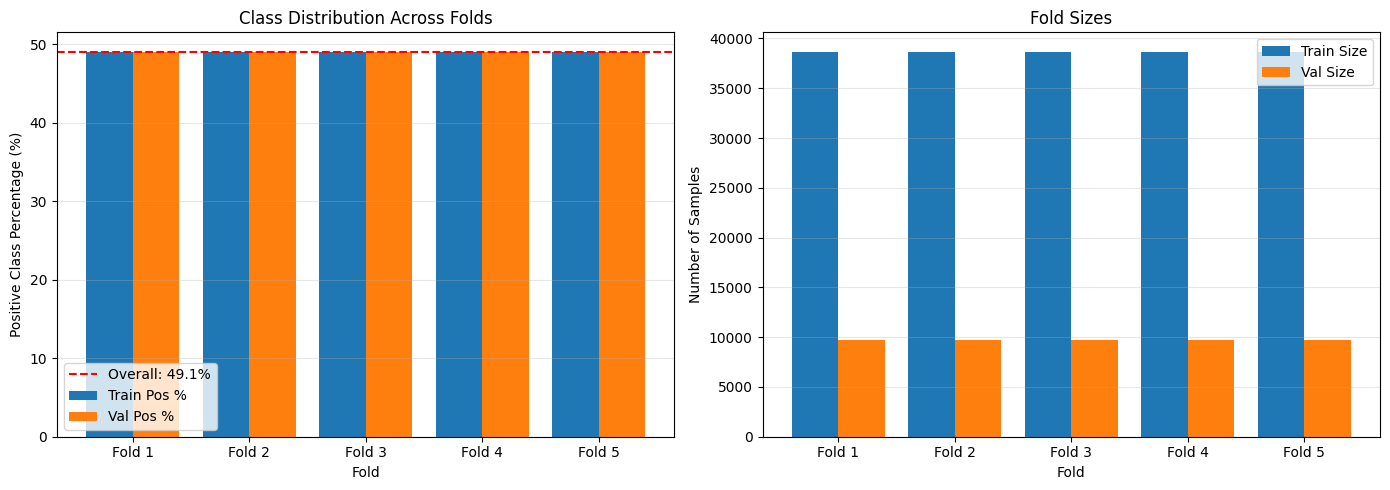


✅ K-Fold validation complete!


In [49]:
# Kiểm tra phân bố class trong từng fold
print("📊 Class Distribution trong các Fold:")
print("-"*60)

fold_stats = []
for fold_idx, (train_idx, val_idx) in enumerate(fold_splits, 1):
    y_train_fold = y_train_full[train_idx]
    y_val_fold = y_train_full[val_idx]
    
    train_pos_pct = (y_train_fold == 1).mean() * 100
    val_pos_pct = (y_val_fold == 1).mean() * 100
    
    fold_stats.append({
        'Fold': fold_idx,
        'Train Size': len(train_idx),
        'Val Size': len(val_idx),
        'Train Pos %': train_pos_pct,
        'Val Pos %': val_pos_pct
    })
    
    print(f"Fold {fold_idx}: Train={len(train_idx):,} (Pos: {train_pos_pct:.1f}%) | "
          f"Val={len(val_idx):,} (Pos: {val_pos_pct:.1f}%)")

fold_df = pd.DataFrame(fold_stats)
print("\n📈 Statistics:")
print(fold_df.describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Distribution of positive class across folds
ax1 = axes[0]
fold_df[['Train Pos %', 'Val Pos %']].plot(kind='bar', ax=ax1, width=0.8)
ax1.axhline(y=y_train_full.mean()*100, color='red', linestyle='--', 
            label=f'Overall: {y_train_full.mean()*100:.1f}%')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Positive Class Percentage (%)')
ax1.set_title('Class Distribution Across Folds')
ax1.set_xticklabels([f'Fold {i+1}' for i in range(N_FOLDS)], rotation=0)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Fold sizes
ax2 = axes[1]
fold_df[['Train Size', 'Val Size']].plot(kind='bar', ax=ax2, width=0.8)
ax2.set_xlabel('Fold')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Fold Sizes')
ax2.set_xticklabels([f'Fold {i+1}' for i in range(N_FOLDS)], rotation=0)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ K-Fold validation complete!")


In [50]:
## 8. Save Data và K-Fold Indices


In [51]:
save_path = 'processed/cardio_train'

# Lưu full training set và test set
np.save(f'{save_path}/X_train_full.npy', X_train_full)
np.save(f'{save_path}/y_train_full.npy', y_train_full)
np.save(f'{save_path}/X_test.npy', X_test)
np.save(f'{save_path}/y_test.npy', y_test)
np.save(f'{save_path}/feature_names.npy', np.array(list(df_numeric.drop('cardio', axis=1).columns)))

# Lưu K-Fold indices
# Mỗi fold sẽ có train_idx và val_idx
fold_dict = {}
for fold_idx, (train_idx, val_idx) in enumerate(fold_splits, 1):
    fold_dict[f'fold_{fold_idx}_train_idx'] = train_idx
    fold_dict[f'fold_{fold_idx}_val_idx'] = val_idx

# Lưu dictionary chứa tất cả fold indices
np.save(f'{save_path}/kfold_indices.npy', fold_dict)

# Lưu metadata về K-Fold
import json
kfold_metadata = {
    'n_splits': N_FOLDS,
    'random_state': 42,
    'shuffle': True,
    'train_size': len(X_train_full),
    'test_size': len(X_test),
    'fold_keys': list(fold_dict.keys())
}
with open(f'{save_path}/kfold_metadata.json', 'w') as f:
    json.dump(kfold_metadata, f, indent=2)

print(f"✅ Saved to {save_path}/")
print(f"   - X_train_full.npy: {X_train_full.shape}")
print(f"   - X_test.npy: {X_test.shape}")
print(f"   - kfold_indices.npy: {N_FOLDS} folds")
print(f"   - kfold_metadata.json: K-Fold configuration")


✅ Saved to processed/cardio_train/
   - X_train_full.npy: (48351, 10)
   - X_test.npy: (12088, 10)
   - kfold_indices.npy: 5 folds
   - kfold_metadata.json: K-Fold configuration


In [52]:
# Verify saved files
print("📁 Saved files:")
print("-"*60)
for f in sorted(os.listdir(save_path)):
    if f.endswith('.npy'):
        data = np.load(f'{save_path}/{f}', allow_pickle=True)
        if isinstance(data, dict):
            print(f"{f}: {len(data)} fold indices")
        else:
            print(f"{f}: {data.shape}")
    elif f.endswith('.json'):
        print(f"{f}: metadata file")


📁 Saved files:
------------------------------------------------------------
X_test.npy: (12088, 10)
X_train.npy: (42307, 10)
X_train_full.npy: (48351, 10)
X_valid.npy: (9066, 10)
feature_names.npy: (10,)
kfold_indices.npy: ()
kfold_metadata.json: metadata file
y_test.npy: (12088,)
y_train.npy: (42307,)
y_train_full.npy: (48351,)
y_valid.npy: (9066,)
